In [1]:
import math
import numpy as np
import pandas as pd
import scipy
import pickle
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

### Metodos

In [2]:
def print_report_from_file(report_df):
    print(classification_report(report_df["anomalo"], report_df["pred_anomalo"]))
    conf_mat = confusion_matrix(report_df["anomalo"], report_df["pred_anomalo"])
    fpr, tpr, thresholds = roc_curve(report_df["anomalo"], report_df["pred_anomalo"], pos_label=True)
    roc_auc = auc(fpr, tpr)
    sn.heatmap(conf_mat, annot=True, fmt='g').set_title("Matriz de confusion")
    plt.show()

    plt.title('Curva ROC')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
def detect_with_kmeans(kmeans_model, tuple_data, max_distance):
    distances_2_centroids = kmeans_model.transform([tuple_data])
    closest_centroid = np.argmin(distances_2_centroids)
    anomal_tuple = False
    if distances_2_centroids[0][closest_centroid] > max_distance:
        anomal_tuple = True
    return anomal_tuple

def detect_with_interpolation(tuple_data, pca, interpolation_func, max_distance):
    distancia = math.inf
    anomal_tuple = False
    tuple_2d = pca.transform([tuple_data])[0]
    try:
        pred_y = interpolation_func(tuple_2d[0])
        distancia = abs(tuple_2d[1]-pred_y)
        if distancia > max_distance:
            anomal_tuple = True
    except ValueError:
        anomal_tuple = True
    return anomal_tuple

def detect_column_cartpole(tuple_data, pca, max_distance, pc1_left_mean, pc1_right_mean, pc2_max, pc2_min):
    anomal_tuple = True
    tuple_2d = pca.transform([tuple_data])[0]
    if (1+max_distance)*pc1_left_mean <= tuple_2d[0] <= pc1_left_mean*(1-max_distance):
        anomal_tuple = False
    if (1-max_distance)*pc1_right_mean <= tuple_2d[0] <= pc1_right_mean*(1+max_distance):
        anomal_tuple = False

    if tuple_2d[1] > pc2_max or tuple_2d[1] < pc2_min:
        anomal_tuple = True
    return anomal_tuple

### Mountaincar

In [24]:
kmeans_filepath = "kmeans_mountaincar_2048c_norm.pkl"
tuples_filepath = "../ejecuciones_mountaincar/mountaincar_noattack.csv"
normalize = True

# Cargo el modelo de clasificacion de estados anomalos
kmeans_model = pickle.load(open(kmeans_filepath, "rb"))
# Cargo el dataframe de estados seguros
tuples_df = pd.read_csv(tuples_filepath)
if normalize:
    norm_filepath = "minmaxscaler_mountaincar.pkl"
    min_max_scaler = pickle.load(open(norm_filepath, "rb"))
    x_scaled = min_max_scaler.transform(tuples_df.values)
    tuples_df = pd.DataFrame(x_scaled, columns=tuples_df.columns)
# Creo un modelo PCA para reducir la dimensionalidad
pca_model = PCA(n_components=2)
# Entreno el modelo PCA con los estados seguros, igual que en los notebooks
tuples_2d_df = pd.DataFrame(pca_model.fit_transform(tuples_df.values))
# Añado los nombres de las columnas al dataframe de dos dimensiones
tuples_2d_df.columns = ["PC1_2d", "PC2_2d"]
# Creo la funcion de interpolacion lineal
if not normalize:
    linear_interpolation_func = scipy.interpolate.interp1d(tuples_2d_df.PC1_2d, tuples_2d_df.PC2_2d, kind='linear')

In [25]:
mountaincar_report_filename = "../resultados_clasificadores/mountaincar_classification_all.csv"
mountaincar_report = pd.read_csv(mountaincar_report_filename)
if normalize:
    x_scaled = min_max_scaler.transform(mountaincar_report.drop("anomalo", axis=1).values)
    mountaincar_report_norm = pd.DataFrame(x_scaled, columns=tuples_df.columns)
    
mountaincar_report.head()

,state_0,state_1,action,next_state_0,next_state_1,reward,anomalo
0,-0.537745,0.050000,2,-0.536267,0.051478,-1.0,True
1,-0.536267,0.051478,2,-0.583322,0.002945,-1.0,False
2,-0.583322,0.002945,2,-0.578931,0.004391,-1.0,False
3,-0.578931,0.004391,2,-0.523127,0.055804,-1.0,True
4,-0.523127,0.055804,2,-0.515953,0.057174,-1.0,True


[Text(0.5, 1.0, 'Tuplas reporte clasificacion')]

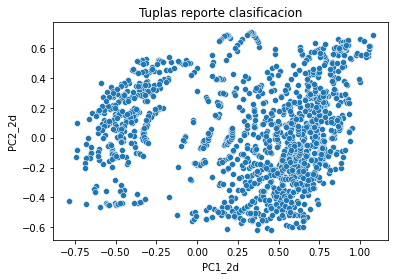

In [26]:
mountaincar_report_2d = pd.DataFrame(pca_model.transform(mountaincar_report_norm.values))
mountaincar_report_2d.columns = ["PC1_2d", "PC2_2d"]
sns.scatterplot(data=mountaincar_report_2d, x='PC1_2d', y='PC2_2d').set(title="Tuplas reporte clasificacion")

In [27]:
idx_to_drop = []
prev_anomalo = False
for idx, row in mountaincar_report.iterrows():
    actual_anomalo = row["anomalo"]
    if prev_anomalo==True and actual_anomalo==False:
        idx_to_drop.append(idx)
    prev_anomalo = actual_anomalo
mountaincar_report.drop(idx_to_drop, axis=0, inplace=True)

              precision    recall  f1-score   support

       False       0.66      0.76      0.71       389
        True       0.85      0.78      0.81       669

    accuracy                           0.77      1058
   macro avg       0.76      0.77      0.76      1058
weighted avg       0.78      0.77      0.77      1058



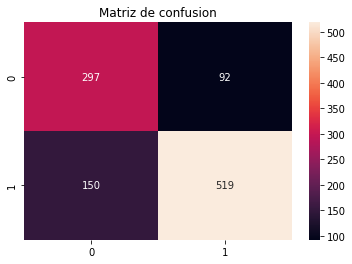

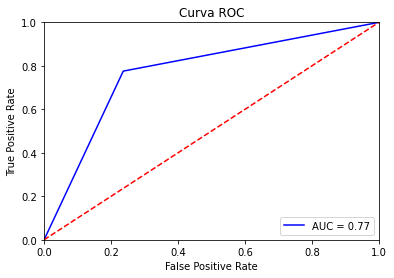

In [28]:
df_resultados = pd.DataFrame(columns=["anomalo", "pred_anomalo"])
for row in mountaincar_report.values:
    anomalo = row[-1]
    tuple_data = row[:-1]
    if normalize:
        tuple_data = min_max_scaler.transform([tuple_data])[0]
    pred_anomalo = detect_with_kmeans(kmeans_model, tuple_data, 0.05)
    # pred_anomalo = detect_with_interpolation(tuple_data, pca_model, linear_interpolation_func, 0.006)
    df_resultados.loc[len(df_resultados)] = [anomalo, pred_anomalo]
print_report_from_file(df_resultados)

### Cartpole

In [40]:
kmeans_filepath = "kmeans_cartpole_2048c_norm.pkl"
tuples_filepath = "../ejecuciones_cartpole/cartpole_noattack.csv"
normalize = True

# Cargo el modelo de clasificacion de estados anomalos
kmeans_model = pickle.load(open(kmeans_filepath, "rb"))
# Cargo el dataframe de estados seguros
tuples_df = pd.read_csv(tuples_filepath)
if normalize:
    norm_filepath = "minmaxscaler_cartpole.pkl"
    min_max_scaler = pickle.load(open(norm_filepath, "rb"))
    x_scaled = min_max_scaler.transform(tuples_df.values)
    tuples_df = pd.DataFrame(x_scaled, columns=tuples_df.columns)
# Creo un modelo PCA para reducir la dimensionalidad
pca_model = PCA(n_components=2)
# Entreno el modelo PCA con los estados seguros, igual que en los notebooks
tuples_2d_df = pd.DataFrame(pca_model.fit_transform(tuples_df.values))
# Añado los nombres de las columnas al dataframe de dos dimensiones
tuples_2d_df.columns = ["PC1_2d", "PC2_2d"]
# Creo la funcion de interpolacion lineal
if not normalize:
    linear_interpolation_func = scipy.interpolate.interp1d(tuples_2d_df.PC1_2d, tuples_2d_df.PC2_2d, kind='linear')

In [42]:
cartpole_report_filename = "../resultados_clasificadores/cartpole_classification_all.csv"
cartpole_report = pd.read_csv(cartpole_report_filename)
if normalize:
    x_scaled = min_max_scaler.transform(cartpole_report.drop("anomalo", axis=1).values)
    cartpole_report_norm = pd.DataFrame(x_scaled, columns=tuples_df.columns)
    
cartpole_report.head()

,state_0,state_1,state_2,state_3,action,next_state_0,next_state_1,next_state_2,next_state_3,reward,anomalo
0,-0.024532,-0.032851,-0.037579,0.016255,0,0.024811,-0.177414,0.012746,0.346849,1.0,True
1,0.024811,-0.177414,0.012746,0.346849,0,0.020262,-0.371986,0.018683,0.627554,1.0,True
2,0.020262,-0.371986,0.018683,0.627554,0,-0.038177,-0.616655,-0.019766,0.860209,1.0,False
3,-0.038177,-0.616655,-0.019766,0.860209,0,-0.050510,-0.811502,-0.002562,1.146612,1.0,False
4,-0.050510,-0.811502,-0.002562,1.146612,0,-0.016740,-0.956591,0.070371,1.488491,1.0,True


[Text(0.5, 1.0, 'Tuplas reporte clasificacion')]

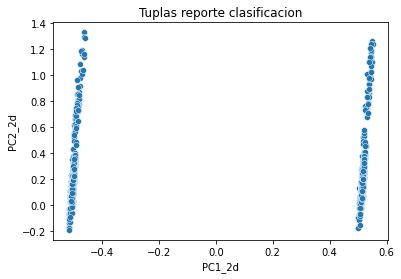

In [43]:
cartpole_report_2d = pd.DataFrame(pca_model.transform(cartpole_report_norm.values))
cartpole_report_2d.columns = ["PC1_2d", "PC2_2d"]
sns.scatterplot(data=cartpole_report_2d, x='PC1_2d', y='PC2_2d').set(title="Tuplas reporte clasificacion")

In [44]:
idx_to_drop = []
prev_anomalo = False
for idx, row in cartpole_report.iterrows():
    actual_anomalo = row["anomalo"]
    if prev_anomalo==True and actual_anomalo==False:
        idx_to_drop.append(idx)
    prev_anomalo = actual_anomalo
cartpole_report.drop(idx_to_drop, axis=0, inplace=True)

              precision    recall  f1-score   support

       False       0.33      0.32      0.33       292
        True       0.62      0.64      0.63       514

    accuracy                           0.52       806
   macro avg       0.48      0.48      0.48       806
weighted avg       0.52      0.52      0.52       806



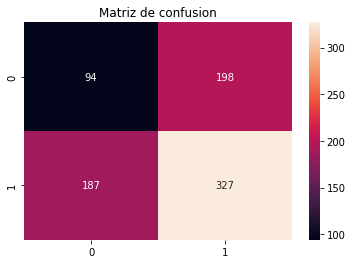

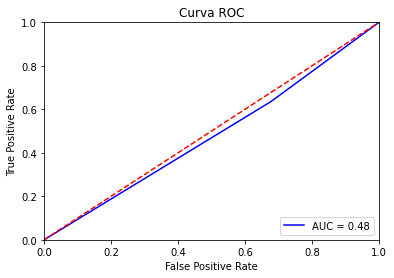

In [49]:
df_resultados = pd.DataFrame(columns=["anomalo", "pred_anomalo"])
for row in cartpole_report.values:
    anomalo = row[-1]
    tuple_data = row[:-1]
    if normalize:
        tuple_data = min_max_scaler.transform([tuple_data])[0]
    pred_anomalo = detect_with_kmeans(kmeans_model, tuple_data, 0.13)
    # pred_anomalo = detect_with_interpolation(tuple_data, pca_model, linear_interpolation_func, 0.006)
    df_resultados.loc[len(df_resultados)] = [anomalo, pred_anomalo]
print_report_from_file(df_resultados)